<p style="text-align:center;">
    <font face="Georgia" size=5 color="red"><b>Import Required libraries</b></font>
</p>



In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.transforms as transforms
from torchsummary import summary
from torch.utils.data import DataLoader
from torchvision import datasets, models
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

# ! pip install open_clip_torch
import open_clip

<p style="text-align:center;">
    <font face="Georgia" size=5 color="red"><b>Load dataset</b></font>
</p>



In [2]:
# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

trainset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
testset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

# Split dataset into seen and unseen classes
seen_classes = list(range(9)) 
unseen_classes = [9]

Files already downloaded and verified
Files already downloaded and verified


<p style="text-align:center;">
    <font face="Georgia" size=5 color="red"><b>prepare dataset</b></font>
</p>



In [3]:
# Prepare dataloaders for seen classes
train_images = []
train_labels = []
test_images = []
test_labels = []

for image, label in trainset:
    if label in seen_classes:
        train_images.append(image)
        train_labels.append(label)

for image, label in testset:
    if label in seen_classes:
        test_images.append(image)
        test_labels.append(label)

# Prepare dataloaders for unseen class
unseen_images = []
unseen_labels = []

for image, label in testset:
    if label in unseen_classes:
        unseen_images.append(image)
        unseen_labels.append(label)

<p style="text-align:center;">
    <font face="Georgia" size=5 color="red"><b>Loading data</b></font>
</p>



In [4]:
# Create data loaders
train_loader = DataLoader(list(zip(train_images, train_labels)), batch_size=64, shuffle=True)
test_loader = DataLoader(list(zip(test_images, test_labels)), batch_size=64, shuffle=False)
unseen_loader = DataLoader(list(zip(unseen_images, unseen_labels)), batch_size=64, shuffle=False)

def print_dataset_info(name, dataset):
    print(f"{name} Dataset Info:")
    print(f"  - Total images: {len(dataset)}")
    print(f"  - Image shape: {dataset[0][0].shape}")
    print("-" * 30)

# Print dataset information
print_dataset_info("Train Set", trainset)
print_dataset_info("Test Set", testset)
print_dataset_info("Unseen Class Set", unseen_images)

Train Set Dataset Info:
  - Total images: 50000
  - Image shape: torch.Size([3, 32, 32])
------------------------------
Test Set Dataset Info:
  - Total images: 10000
  - Image shape: torch.Size([3, 32, 32])
------------------------------
Unseen Class Set Dataset Info:
  - Total images: 1000
  - Image shape: torch.Size([32, 32])
------------------------------


<p style="text-align:center;">
    <font face="Georgia" size=5 color="red"><b>Dataset visualization</b></font>
</p>



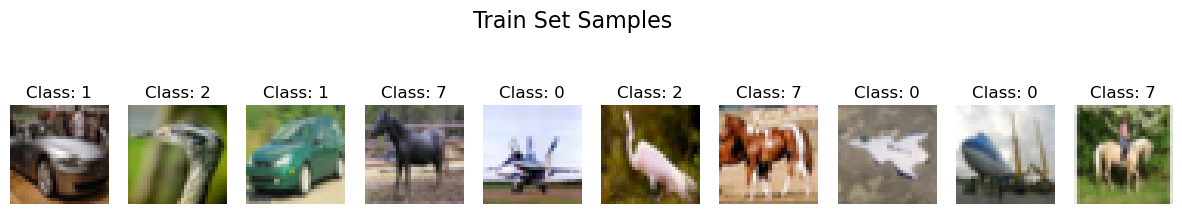

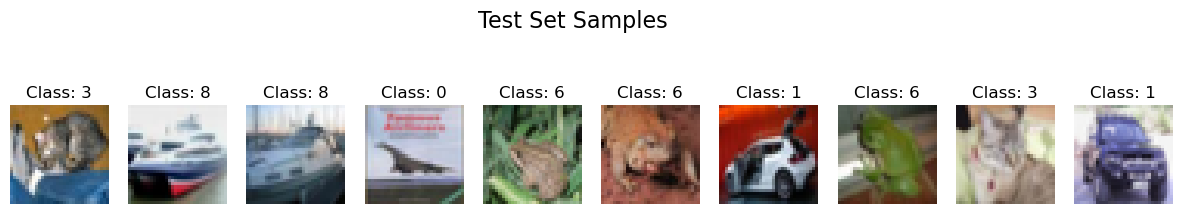

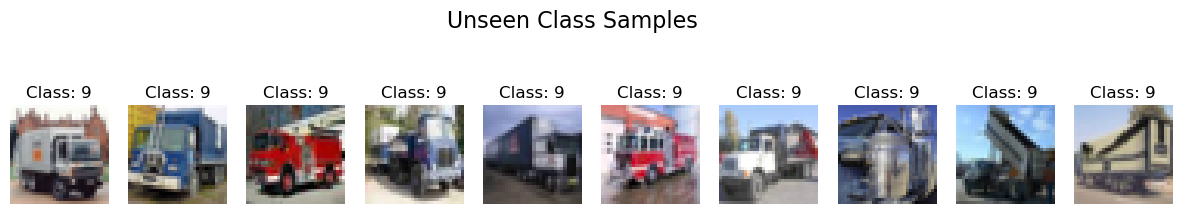

In [5]:
def denormalize(img):
    img = img * 0.5 + 0.5  # Reverse normalization
    img = np.clip(img, 0, 1)  # Ensure values are in valid range
    return img

def visualize_samples(dataloader, title, num_images=10):
    images, labels = next(iter(dataloader))  # Get a batch
    images = images[:num_images]  # Select subset
    labels = labels[:num_images]
    
    fig, axes = plt.subplots(1, num_images, figsize=(15, 3))
    fig.suptitle(title, fontsize=16)
    
    for i, ax in enumerate(axes):
        img = images[i].permute(1, 2, 0).numpy()  # Convert to (H, W, C)
        img = denormalize(img)
        ax.imshow(img)
        ax.set_title(f"Class: {labels[i]}")
        ax.axis("off")
    
    plt.show()

# Visualize samples
visualize_samples(train_loader, "Train Set Samples")
visualize_samples(test_loader, "Test Set Samples")
visualize_samples(unseen_loader, "Unseen Class Samples")

<p style="text-align:center;">
    <font face="Georgia" size=5 color="red"><b>Tokenize text descriptions with CLIP</b></font>
</p>



In [6]:
# Load CLIP model (ViT-L)
clip_model, preprocess, tokenizer = open_clip.create_model_and_transforms("ViT-L-14", pretrained="openai")

# Get tokenizer
tokenizer = open_clip.get_tokenizer("ViT-L-14")

# Class descriptions for seen and unseen categories
class_descriptions = {
    "airplane": "Aerial craft: jet, wings, flight.",
    "automobile": "Passenger vehicle: personal transport, compact size, on-road mobility.",
    "bird": "Feathered creature: avian, wings, flight.",
    "cat": "Feline pet: whiskers, meow, domestic.",
    "deer": "Woodland ungulate: antlers, forest, graze.",
    "dog": "Canine companion: paws, bark, domestic.",
    "frog": "Aquatic amphibian: jump, pond, croak.",
    "horse": "Equine animal: mane, ride, gallop.",
    "ship": "Water vessel: ocean, sail, navigate.",
    "truck": "Heavy-duty vehicle: freight transport, large capacity, industrial use."
}

# Convert class descriptions into a list for batch processing
class_texts = list(class_descriptions.values())

# Tokenize text descriptions
with torch.no_grad():
    text_inputs = tokenizer(class_texts) 
    text_embeddings = clip_model.encode_text(text_inputs)

# Convert embeddings to a dictionary
label_embeddings = {label: emb for label, emb in zip(class_descriptions.keys(), text_embeddings)}

print(f"Generated {len(label_embeddings)} CLIP text embeddings with shape: {text_embeddings.shape}")


c:\Users\amirr\anaconda3\lib\site-packages\open_clip\factory.py:388: UserWarning: These pretrained weights were trained with QuickGELU activation but the model config does not have that enabled. Consider using a model config with a "-quickgelu" suffix or enable with a flag.
  warnings.warn(


Generated 10 CLIP text embeddings with shape: torch.Size([10, 768])


<p style="text-align:center;">
    <font face="Georgia" size=5 color="red"><b>Define VAE architecture for ZSL</b></font>
</p>



<p style="text-align:left;">
    <font face="Georgia" size=5 color="green"><b>Encoder</b></font>
</p>



In [7]:
class CLIP_Encoder(nn.Module):
    def __init__(self, clip_embedding_dim=768):  # CLIP ViT-L-14 has 768 dimensions
        super(CLIP_Encoder, self).__init__()
        resnet = models.resnet50(pretrained=True)
        self.feature_extractor = nn.Sequential(*list(resnet.children())[:-1])  # Remove last FC layer
        self.fc = nn.Linear(2048, clip_embedding_dim)  # Map ResNet features to CLIP space

    def forward(self, x):
        x = self.feature_extractor(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x
    
encoder = CLIP_Encoder()
print("\n--- Using torchsummary ---")
summary(encoder, (3, 32, 32), device="cpu")

c:\Users\amirr\anaconda3\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\amirr\anaconda3\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)



--- Using torchsummary ---
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 16, 16]           9,408
       BatchNorm2d-2           [-1, 64, 16, 16]             128
              ReLU-3           [-1, 64, 16, 16]               0
         MaxPool2d-4             [-1, 64, 8, 8]               0
            Conv2d-5             [-1, 64, 8, 8]           4,096
       BatchNorm2d-6             [-1, 64, 8, 8]             128
              ReLU-7             [-1, 64, 8, 8]               0
            Conv2d-8             [-1, 64, 8, 8]          36,864
       BatchNorm2d-9             [-1, 64, 8, 8]             128
             ReLU-10             [-1, 64, 8, 8]               0
           Conv2d-11            [-1, 256, 8, 8]          16,384
      BatchNorm2d-12            [-1, 256, 8, 8]             512
           Conv2d-13            [-1, 256, 8, 8]          16,384
      Batch

<p style="text-align:left;">
    <font face="Georgia" size=5 color="green"><b>Decoder</b></font>
</p>


In [8]:
class CLIP_Decoder(nn.Module):
    def __init__(self, clip_embedding_dim=768):
        super(CLIP_Decoder, self).__init__()
        
        self.decoder_layers = nn.Sequential(
            nn.Linear(clip_embedding_dim, 1024),
            nn.LayerNorm(1024),
            nn.ReLU(),
            
            nn.Linear(1024, 1024),
            nn.LayerNorm(1024),
            nn.ReLU(),
            
            nn.Linear(1024, 1024),
            nn.LayerNorm(1024),
            nn.ReLU(),
            
            nn.Linear(1024, clip_embedding_dim),
        )
        
        # normalization layer to match CLIP's normalized embeddings
        self.normalize = lambda x: x / x.norm(dim=-1, keepdim=True)
        
    def forward(self, z):
        decoded = self.decoder_layers(z)
        decoded = self.normalize(decoded)
        
        return decoded
    
decoder = CLIP_Decoder()
print("\n--- Using torchsummary ---")
summary(decoder, (768,), device="cpu")


--- Using torchsummary ---
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                 [-1, 1024]         787,456
         LayerNorm-2                 [-1, 1024]           2,048
              ReLU-3                 [-1, 1024]               0
            Linear-4                 [-1, 1024]       1,049,600
         LayerNorm-5                 [-1, 1024]           2,048
              ReLU-6                 [-1, 1024]               0
            Linear-7                 [-1, 1024]       1,049,600
         LayerNorm-8                 [-1, 1024]           2,048
              ReLU-9                 [-1, 1024]               0
           Linear-10                  [-1, 768]         787,200
Total params: 3,680,000
Trainable params: 3,680,000
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.08
Pa

In [9]:
class VAE_GAN_CLIP(nn.Module):
    def __init__(self):
        super(VAE_GAN_CLIP, self).__init__()
        self.encoder = encoder
        self.decoder = decoder

    def forward(self, x):
        mu, logvar = self.encoder(x), torch.zeros_like(x)
        z = mu
        clip_recon = self.decoder(z)
        return clip_recon, mu, logvar


In [10]:
def clip_loss(clip_recon, text_embeddings):
    # Normalize both embeddings to unit length
    clip_recon_norm = F.normalize(clip_recon, p=2, dim=1)
    text_embeddings_norm = F.normalize(text_embeddings, p=2, dim=1)
    
    # Compute cosine similarity (results in values between -1 and 1)
    similarity = torch.sum(clip_recon_norm * text_embeddings_norm, dim=1)
    
    # Convert to a loss (higher similarity → lower loss)
    # 1 - similarity gives us values between 0 and 2
    return torch.mean(1 - similarity)

<p style="text-align:center;">
    <font face="Georgia" size=5 color="red"><b>Initialize the model</b></font>
</p>



In [11]:
# Initialize the model and optimizer 
vae_gan_clip = VAE_GAN_CLIP().to(device)
optimizer = torch.optim.Adam(vae_gan_clip.parameters(), lr=1e-4)

<p style="text-align:center;">
    <font face="Georgia" size=5 color="red"><b>Training</b></font>
</p>



In [12]:
num_epochs = 30

# Training loop
for epoch in range(num_epochs):
    total_loss = 0
    batches = 0
    
    for images, labels in train_loader:
        images = images.to(device)
        
        # Get text embeddings for the current batch based on class labels
        batch_text_embeddings = torch.stack([text_embeddings[label] for label in labels]).to(device)
        
        # Forward pass through the model
        clip_features, mu, logvar = vae_gan_clip(images)
        
        # Compute CLIP loss
        loss = clip_loss(clip_features, batch_text_embeddings)
        
        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
        batches += 1
    
    # Print epoch statistics
    avg_loss = total_loss / batches
    print(f"Epoch [{epoch+1}/{num_epochs}] - Avg CLIP Loss: {avg_loss:.4f}")

Epoch [1/30] - Avg CLIP Loss: 0.0853
Epoch [2/30] - Avg CLIP Loss: 0.0371
Epoch [3/30] - Avg CLIP Loss: 0.0252
Epoch [4/30] - Avg CLIP Loss: 0.0186
Epoch [5/30] - Avg CLIP Loss: 0.0146
Epoch [6/30] - Avg CLIP Loss: 0.0123
Epoch [7/30] - Avg CLIP Loss: 0.0104
Epoch [8/30] - Avg CLIP Loss: 0.0087
Epoch [9/30] - Avg CLIP Loss: 0.0083
Epoch [10/30] - Avg CLIP Loss: 0.0069
Epoch [11/30] - Avg CLIP Loss: 0.0066
Epoch [12/30] - Avg CLIP Loss: 0.0058
Epoch [13/30] - Avg CLIP Loss: 0.0055
Epoch [14/30] - Avg CLIP Loss: 0.0061
Epoch [15/30] - Avg CLIP Loss: 0.0048
Epoch [16/30] - Avg CLIP Loss: 0.0056
Epoch [17/30] - Avg CLIP Loss: 0.0042
Epoch [18/30] - Avg CLIP Loss: 0.0041
Epoch [19/30] - Avg CLIP Loss: 0.0044
Epoch [20/30] - Avg CLIP Loss: 0.0050
Epoch [21/30] - Avg CLIP Loss: 0.0040
Epoch [22/30] - Avg CLIP Loss: 0.0044
Epoch [23/30] - Avg CLIP Loss: 0.0034
Epoch [24/30] - Avg CLIP Loss: 0.0037
Epoch [25/30] - Avg CLIP Loss: 0.0045
Epoch [26/30] - Avg CLIP Loss: 0.0035
Epoch [27/30] - Avg C

<p style="text-align:center;">
    <font face="Georgia" size=5 color="red"><b>saving model</b></font>
</p>



In [13]:
# Save the trained model
torch.save(vae_gan_clip.state_dict(), 'vae_gan_clip_model.pth')
print("Model saved successfully as 'vae_gan_clip_model.pth'")

# Optional: Save the text embeddings too
torch.save(text_embeddings, 'clip_text_embeddings.pth')
print("Text embeddings saved successfully as 'clip_text_embeddings.pth'")

Model saved successfully as 'vae_gan_clip_model.pth'
Text embeddings saved successfully as 'clip_text_embeddings.pth'


<p style="text-align:center;">
    <font face="Georgia" size=5 color="red"><b>Loading saved model</b></font>
</p>



In [14]:
# vae_gan_clip = VAE_GAN_CLIP()
# model_state_dict = torch.load('vae_gan_clip_model.pth', map_location=device)
# vae_gan_clip.load_state_dict(model_state_dict)
# vae_gan_clip.to(device)
# print(f"Model moved to {device}.")

# text_embeddings = torch.load('clip_text_embeddings.pth', map_location=device)
# text_embeddings = text_embeddings.to(device)
# print(f"Text embeddings moved to {device}.")

# label_embeddings = {label: emb for label, emb in zip(class_descriptions.keys(), text_embeddings)}

<p style="text-align:center;">
    <font face="Georgia" size=5 color="red"><b>Evaluating model performance</b></font>
</p>



In [15]:
print(class_descriptions.keys())

dict_keys(['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck'])


In [18]:
print("Evaluating on unseen class...")
vae_gan_clip.eval()

# Dictionary to store average similarities for each class
class_similarities = {}
truck_ditection_rate = {}
total = 0
truck_detected = 0

for cls_name in list(class_descriptions.keys()):
    if cls_name == 'truck':
        with torch.no_grad():
            # Get the class embedding
            class_embedding = label_embeddings[cls_name].to(device)
            class_embedding = F.normalize(class_embedding, p=2, dim=0)
            
            all_similarities = []
            
            for data, targets in unseen_loader:
                data = data.to(device)
                
                # Get the latent representation
                encoder_output = vae_gan_clip.encoder(data)
                
                # Generate CLIP embeddings
                generated_embeddings = vae_gan_clip.decoder(encoder_output)
                
                # Normalize embeddings for cosine similarity
                generated_embeddings = F.normalize(generated_embeddings, p=2, dim=1)
                
                # Calculate similarity with class embedding
                similarities = torch.mm(generated_embeddings, class_embedding.unsqueeze(1)).squeeze()
                
                # Collect all similarities
                all_similarities.append(similarities.cpu())
    
                # Count how many samples exceed a similarity threshold
                threshold = 0.7
                truck_detected += (similarities > threshold).sum().item()
                total += targets.size(0)
            
            # Concatenate all similarities and calculate average
            all_similarities = torch.cat(all_similarities)
            avg_similarity = all_similarities.mean().item()
            
            # Store the average similarity for this class
            class_similarities[cls_name] = avg_similarity
            truck_ditection_rate[cls_name] = 100 * truck_detected / total

   
print(f"\naverage similarity to truck images: \033[92m\033[1m{avg_similarity:.4f}\033[0m")

print()
detection_rate = 100 * truck_detected / total
print('*' * 15)
print(f"Truck detection rate on unseen class with {threshold} similarity threshold: \033[92m\033[1m{detection_rate:.2f}%\033[0m")
print('*' * 15)

Evaluating on unseen class...

average similarity to truck images: 0.8438

***************
Truck detection rate on unseen class with 0.7 similarity threshold: 99.30%
***************


<p style="text-align:center;">
    <font face="Georgia" size=5 color="red"><b>Visualization for generated embedding</b></font>
</p>



Generating embeddings for visualization...


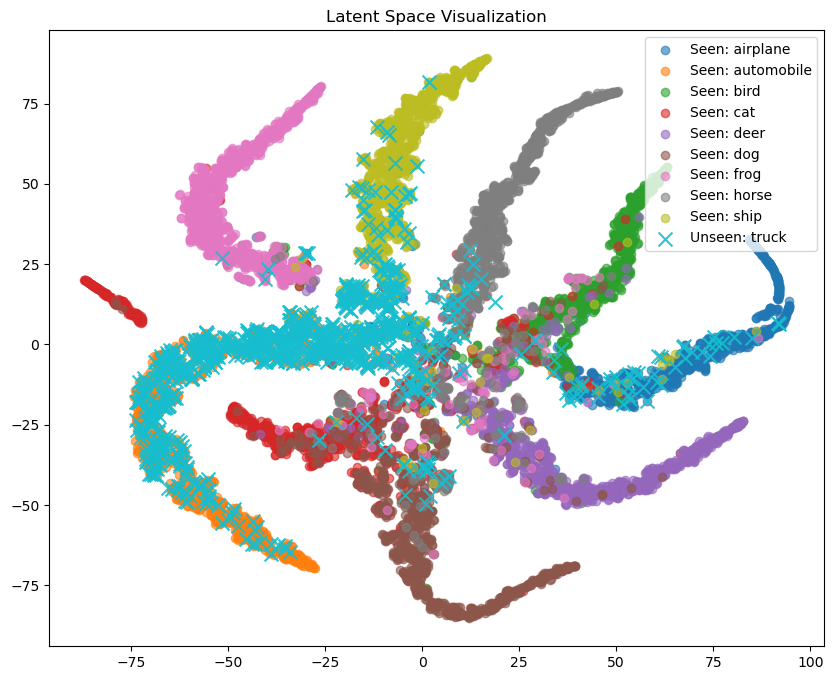

In [19]:
# Visualization Generate embeddings for unseen class
print("Generating embeddings for visualization...")

def visualize_latent_space(model, test_loader, unseen_loader, device):
    model.eval()
    seen_latents = []
    seen_labels = []
    unseen_latents = []
    unseen_labels = []
    
    # Create a mapping of class indices to class names
    classes = list(class_descriptions.keys())
    
    with torch.no_grad():
        # Process seen classes
        for data, targets in test_loader:
            data = data.to(device)
            mu= model.encoder(data)  # Unpacking both mu and logvar
            seen_latents.append(mu.cpu().numpy())
            seen_labels.append(targets.cpu().numpy())  # Use cpu() before numpy()
        
        # Process unseen class
        for data, targets in unseen_loader:
            data = data.to(device)
            mu = model.encoder(data)  # Unpacking both mu and logvar
            unseen_latents.append(mu.cpu().numpy())
            unseen_labels.append(targets.cpu().numpy())  # Use cpu() before numpy()
    
    seen_latents = np.concatenate(seen_latents, axis=0)
    seen_labels = np.concatenate(seen_labels, axis=0)
    unseen_latents = np.concatenate(unseen_latents, axis=0)
    unseen_labels = np.concatenate(unseen_labels, axis=0)
    
    combined_latents = np.vstack([seen_latents, unseen_latents])
    tsne = TSNE(n_components=2, random_state=42)
    transformed_latents = tsne.fit_transform(combined_latents)
    seen_latents_2d = transformed_latents[:len(seen_latents)]
    unseen_latents_2d = transformed_latents[len(seen_latents):]
    
    plt.figure(figsize=(10, 8))
    
    # Plot seen classes
    for label in np.unique(seen_labels):
        idx = seen_labels == label
        class_name = classes[label] if label < len(classes) else f"Class {label}"
        plt.scatter(seen_latents_2d[idx, 0], seen_latents_2d[idx, 1], 
                   label=f"Seen: {class_name}", alpha=0.6)
    
    # Plot unseen class
    for label in np.unique(unseen_labels):
        idx = unseen_labels == label
        class_name = classes[label] if label < len(classes) else f"Class {label}"
        plt.scatter(unseen_latents_2d[idx, 0], unseen_latents_2d[idx, 1], 
                   label=f"Unseen: {class_name}", marker='x', s=100, alpha=0.9)
    
    plt.legend()
    plt.title("Latent Space Visualization")
    plt.savefig("latent_space.png")
    plt.show()

visualize_latent_space(vae_gan_clip, test_loader, unseen_loader, device)